# Generate tables for analysis

In [1]:
%load_ext autoreload
%autoreload 2

from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import utils

pd.set_option('display.max_columns', 150)
pd.options.display.float_format = '{:,.5f}'.format
sns.set_theme(style="darkgrid")

LARGE_CORP_MIN_SALES = 50
MED_CORP_MIN_SALES = 10

def format_thousands(value, tick_number):
    if value >= 1000:
        value = int(value) // 1000
        return f"{value}K"
    else:
        return int(value)
    
# classify grantee/grantor by corp size
def classify_corp(x):
    if x > LARGE_CORP_MIN_SALES:
        return 3
    elif x > MED_CORP_MIN_SALES:
        return 2
    else:
        return 1

In [12]:
DATA_PATH = 'output/'

digest = pd.read_parquet(DATA_PATH + 'digest_full_final.parquet')
sales = pd.read_parquet(DATA_PATH + 'sales_full_final.parquet')
valid_sales = pd.read_parquet(DATA_PATH + 'sales_full_valid.parquet')

parcel_geo = pd.read_csv(DATA_PATH + 'parcels_geo.csv')
nsa_geo = gpd.read_file('data/atl_nsa.geojson')
nsa_stats = pd.read_csv('data/atl_nsa_stats.csv')

print(f"Len digest: {len(digest)}")
print(f"Len sales: {len(sales)}")
print(f"Len valid_sales: {len(valid_sales)}")

Len digest: 2747506
Len sales: 150284
Len valid_sales: 112689


## Merge geodata with parcels and sales

In [13]:
# Convert "Saledt" to "Sale Year"
sales["Sale Year"] = sales["Saledt"].apply(lambda x: x.split("-")[-1]).astype(int)

digest = digest.merge(parcel_geo, on='PARID', how='left')
sales = sales.merge(parcel_geo, on='PARID', how='left')

invalid_sales = sales[sales["Saleval"] != "0"]
invalid_atl = invalid_sales[invalid_sales["neighborhood"].notna()]

digest_atl = digest[digest["neighborhood"].isna()]
sales_atl = sales[sales["neighborhood"].isna()]

print(f"Parcel records in ATL: {len(digest_atl)}")
print(f"Sale records in ATL: {len(sales_atl)}")

print(f"Len invalid_sales: {len(invalid_sales)}")
print(f"Len invalid_atl: {len(invalid_atl)}")

Parcel records in ATL: 1759894
Sale records in ATL: 94830
Len invalid_sales: 37595
Len invalid_atl: 17465


## Figure 1. Total SFH Sales in Fulton County and Atlanta

In [5]:
dfs = []

# Calculate total and invalid sale count by year for Fulton and Atlanta
df = sales
for i in ["Total", "Invalid"]:
    df = invalid_sales if i == "Invalid"

    dfs.append(pd.DataFrame(
        df.groupby("Sale Year")["PARID"].count()
    ).rename(columns={"PARID": f"{i} Fulton"}).reset_index())

    dfs.append(pd.DataFrame(
        df[
            df["neighborhood"].notna()
        ].groupby("Sale Year")["PARID"].count()
    ).rename(columns={"PARID": f"{i} Atlanta"}).reset_index())

total_sales = reduce(lambda left, right: pd.merge(left, right, on='Sale Year'), dfs)

In [7]:
# Invalid Fulton Excl of Atlanta (take invalid sales where neighborhood is null)
total_sales = total_sales.merge(pd.DataFrame(invalid_sales[valid_sales["neighborhood"].isna()].groupby(
    "Sale Year"
)["PARID"].count()).rename(columns={
    "PARID": "Valid Fulton Excl Atlanta"
}),
    on="Sale Year",
    how="left"
).fillna(0)                

total_sales["Invalid Atlanta"] = total_sales["Total Atlanta"] - total_sales["Valid Atlanta"]

total_sales["Invalid Fulton Excl Atlanta"] = (
    total_sales["Total Fulton"]
    - total_sales["Valid Fulton Excl Atlanta"]
    - total_sales["Valid Atlanta"]
    - total_sales["Invalid Atlanta"]
)

total_sales = total_sales.merge(
    total_sales[
        ["Valid Fulton Excl Atlanta", "Invalid Fulton Excl Atlanta", "Valid Atlanta", "Invalid Atlanta"]
    ].divide(total_sales["Total Fulton"], axis=0),
    left_index=True, right_index=True, suffixes=("", " %")
)

total_sales

KeyError: 'Valid Fulton Excl Atlanta'

NOTE: is this correctly excluding ATL from first total

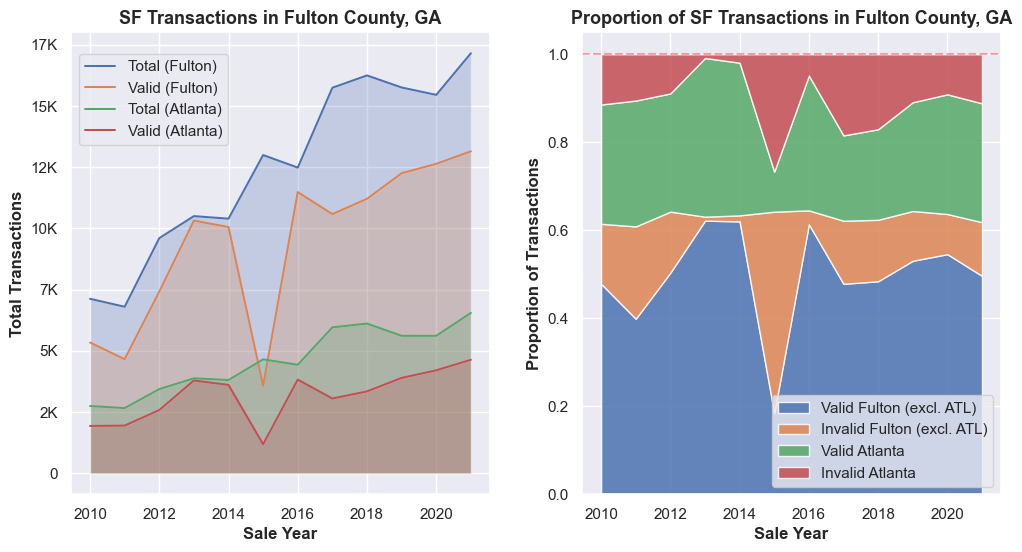

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'wspace': .22})

utils.area_plot(
    total_sales,
    "Sale Year",
    ["Total Fulton", "Valid Fulton", "Total Atlanta", "Valid Atlanta"],
    ["Total (Fulton)", "Valid (Fulton)", "Total (Atlanta)", "Valid (Atlanta)"],
    "Sale Year",
    "Total Transactions",
    title="SF Transactions in Fulton County, GA",
    ax=ax[0],
    format_func=format_thousands,
    format_tuple=(0, 1),
    legend={"loc": "upper left", "bbox_to_anchor": (0, 0.97)}
)

utils.stacked_plot(
    total_sales,
    "Sale Year",
    ["Valid Fulton Outside Atlanta %", "Invalid Fulton Outside Atlanta %", "Valid Atlanta %", "Invalid Atlanta %"],
    ["Valid Fulton (excl. ATL)", "Invalid Fulton (excl. ATL)", "Valid Atlanta", "Invalid Atlanta"],
    "Sale Year",
    y_label="Proportion of Transactions",
    title="Proportion of SF Transactions in Fulton County, GA",
    ax=ax[1],
    format_func=format_thousands,
    legend={"loc": "lower right"},
    opacity=.85
)

ax[1].axhline(y=1, color='red', linestyle='--', alpha=.35)

## Figure 2. Total Sales by Corporates and Table of Invalid Sales

In [8]:
dfs = [total_sales] + []
df = sales

names = {"GRANTEE_corp_flag": "Corporate Purchases", "GRANTOR_corp_flag": "Corporate Sales"}

for type in ["Total", "Invalid"]:
    if type == "Invalid":
        df = invalid_sales
    else:
        df = sales

    for i in ['GRANTEE_corp_flag', 'GRANTOR_corp_flag']:   
        dfs.append(pd.DataFrame(
            df[
                (df[i] == 1)
                & (df["neighborhood"].notna())
            ].groupby("Sale Year")["PARID"].count()
        ).rename(columns={"PARID": f"{type} {names[i]} Atlanta"}).reset_index())
        
total_sales = reduce(lambda left, right: pd.merge(left, right, on='Sale Year'), dfs)

total_sales = total_sales.merge(
    total_sales[
        ["Total Corporate Sales Atlanta", "Total Corporate Purchases Atlanta"]
    ].divide(total_sales["Total Atlanta"], axis=0),
    left_index=True, right_index=True, suffixes=("", " %")
).merge(
    total_sales[
        ["Invalid Corporate Purchases Atlanta", "Invalid Corporate Sales Atlanta"]
    ].divide(total_sales["Invalid Atlanta"], axis=0),
    left_index=True, right_index=True, suffixes=("", " %") 
)

total_sales

,Sale Year,Total Fulton,Total Atlanta,Valid Fulton,Valid Atlanta,Valid Fulton %,Total Atlanta %,Valid Atlanta %,Valid %,Valid Fulton Outside Atlanta,Invalid Atlanta,Invalid Fulton Outside Atlanta,Valid Fulton Outside Atlanta %,Invalid Fulton Outside Atlanta %,Invalid Atlanta %,Total Corporate Purchases Atlanta,Total Corporate Sales Atlanta,Invalid Corporate Purchases Atlanta,Invalid Corporate Sales Atlanta,Total Corporate Sales Atlanta %,Total Corporate Purchases Atlanta %,Invalid Corporate Purchases Atlanta %,Invalid Corporate Sales Atlanta %
0,2010,7126,2746,5340,1932,0.74937,0.38535,0.27112,0.74937,3408,814,972,0.47825,0.13640,0.11423,660,941,372,403,0.34268,0.24035,0.45700,0.49509
1,2011,6801,2661,4658,1945,0.68490,0.39127,0.28599,0.68490,2713,716,1427,0.39891,0.20982,0.10528,629,856,342,340,0.32168,0.23638,0.47765,0.47486
2,2012,9604,3435,7417,2580,0.77228,0.35766,0.26864,0.77228,4837,855,1332,0.50364,0.13869,0.08903,978,1040,500,325,0.30277,0.28472,0.58480,0.38012
3,2013,10503,3877,10319,3788,0.98248,0.36913,0.36066,0.98248,6531,89,95,0.62182,0.00905,0.00847,1123,1231,67,30,0.31751,0.28966,0.75281,0.33708
4,2014,10399,3808,10057,3608,0.96711,0.36619,0.34696,0.96711,6449,200,142,0.62016,0.01366,0.01923,957,1096,166,61,0.28782,0.25131,0.83000,0.30500
5,2015,12998,4651,3576,1183,0.27512,0.35782,0.09101,0.27512,2393,3468,5954,0.18411,0.45807,0.26681,1193,1385,1084,1122,0.29779,0.25650,0.31257,0.32353
6,2016,12485,4430,11485,3825,0.91990,0.35483,0.30637,0.91990,7660,605,395,0.61354,0.03164,0.04846,1031,1515,334,274,0.34199,0.23273,0.55207,0.45289
7,2017,15748,5958,10585,3053,0.67215,0.37833,0.19387,0.67215,7532,2905,2258,0.47828,0.14338,0.18447,1962,2328,1769,1423,0.39074,0.32931,0.60895,0.48985
8,2018,16250,6114,11209,3343,0.68978,0.37625,0.20572,0.68978,7866,2771,2270,0.48406,0.13969,0.17052,2138,2536,1909,1367,0.41479,0.34969,0.68892,0.49332
9,2019,15758,5614,12255,3894,0.77770,0.35626,0.24711,0.77770,8361,1720,1783,0.53059,0.11315,0.10915,1377,2187,1109,732,0.38956,0.24528,0.64477,0.42558


In [9]:
q

NameError: name 'q' is not defined

In [ ]:
# Total Atlanta - Valid Atlanta = Invalid Atlanta
# Total Corp Purchases - Valid Corp Purchases = Invalid Corp Purchases
# Total Corp Sales - Valid Corp Sales = Invalid Corp Sales


In [ ]:
total_sales["Total Corporate Transactions Atlanta"] = total_sales["Total Corporate Sales Atlanta"] + total_sales["Total Corporate Purchases Atlanta"]
total_sales["Total Valid Corp Trans Atlanta"] = total_sales["Valid Corporate Sales Atlanta"] + total_sales["Valid Corporate Purchases Atlanta"]
total_sales["Total Invalid Corp Trans Atlanta"] = total_sales["Total Corporate Transactions Atlanta"] - total_sales["Total Valid Corp Trans Atlanta"]
total_sales["Proportion Invalid Atlanta"] = total_sales["Total Invalid Corp Trans Atlanta"].divide(total_sales["Total Corporate Transactions Atlanta"], axis=0)

total_sales["Top Invalid Saleval Code"] = pd.DataFrame(sales[
    (sales["GRANTOR_corp_flag"] == 1)
    & (sales["Saleval"] != "0")
].groupby("Sale Year")["Saleval"].value_counts()).reset_index().drop_duplicates(
    subset='Sale Year'
)["Saleval"].reset_index(drop=True)

total_sales[
    ["Sale Year", "Total Atlanta", "Total Corporate Purchases Atlanta", "Total Corporate Sales Atlanta",
     "Valid Corporate Purchases Atlanta", "Valid Corporate Sales Atlanta",
     "Total Corporate Transactions Atlanta", "Total Invalid Corp Trans Atlanta", "Proportion Invalid Atlanta",
     "Top Invalid Saleval Code"]
]

KeyError: 'Valid Corporate Sales Atlanta'

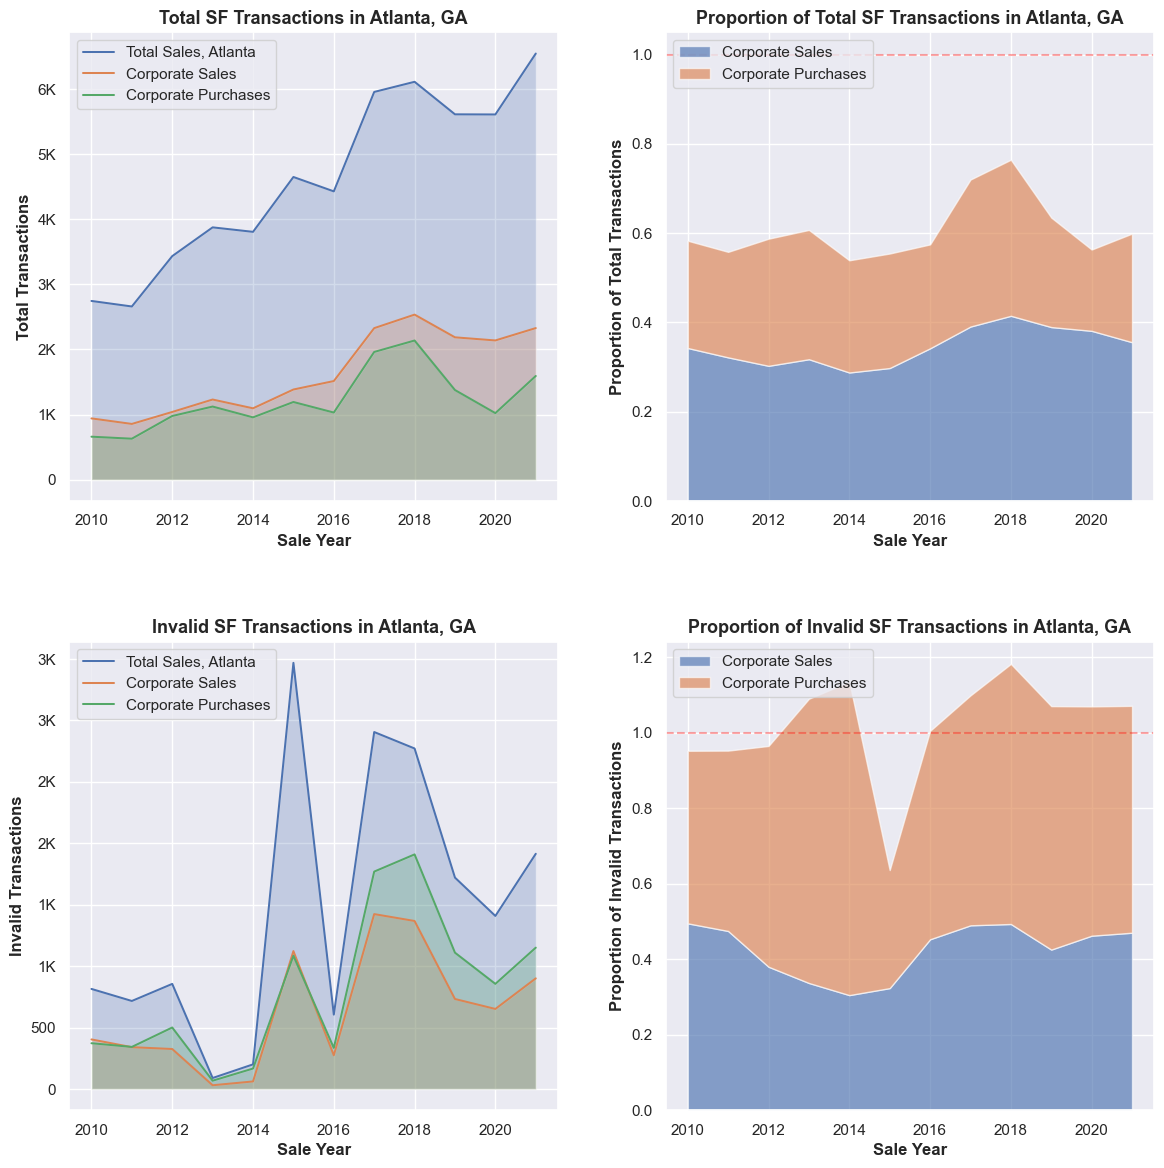

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(14, 14), gridspec_kw={'wspace': .22, 'hspace': .3})

area = "Atlanta"
for row in range(2): # 0 = Total Fulton, 1 = Valid Fulton, 2 = Total Atlanta, 3 = Valid Atlanta
    if row == 1:
        sale_type = "Invalid"
    else:
        sale_type = "Total"

    utils.area_plot(
        total_sales,
        "Sale Year",
        [f"{sale_type} {area}", f"{sale_type} Corporate Sales {area}", f"{sale_type} Corporate Purchases {area}"],
        [f"Total Sales, {area}", "Corporate Sales", "Corporate Purchases"],
        "Sale Year",
        f"{sale_type} Transactions",
        f"{sale_type} SF Transactions in {area}, GA",
        ax=ax[row][0],
        format_func=format_thousands,
        format_tuple=(0, 1),
        legend={"loc": "upper left"}
    )
# TODO switch to invalid
    utils.stacked_plot(
        total_sales,
        "Sale Year",
        [f"{sale_type} Corporate Sales {area} %", f"{sale_type} Corporate Purchases {area} %"],
        ["Corporate Sales", "Corporate Purchases"],
        "Sale Year",
        y_label=f"Proportion of {sale_type} Transactions",
        title=f"Proportion of {sale_type} SF Transactions in {area}, GA",
        ax=ax[row][1],
        opacity=.65,
        legend={"loc": "upper left"}
    )
    
    ax[row][1].axhline(y=1, color='red', linestyle='--', alpha=.35)

## Figure 3. Sales by Transaction Scale
Note: switch with Figure 2 (e.g. this figure should come before previous) for paper

In [ ]:
# Note includes valid sales and purchases from govt, bank
sale_scale = pd.read_csv("output/sale_scale.csv")
sale_scale["TAXYR"] = (sale_scale["TAXYR"].astype(int) - 1)
sale_scale = sale_scale.rename(columns={"TAXYR": "Sale Year"})

In [ ]:
# Want to join sale_scale to sale so we have scale of both GRANTEE and GRANTOR

sales = sales.merge(
    sale_scale[["Sale Year", "entity_addr", "total_trans_fulton"]],
    left_on=["Sale Year", "GRANTEE_match_addr"],
    right_on=["Sale Year", "entity_addr"],
    how="left"
).rename(columns={"total_trans_fulton": "Buyer Transactions Fulton"}).drop(
    columns=["entity_addr"]
).merge(
    sale_scale[["Sale Year", "entity_addr", "total_trans_fulton"]],
    left_on=["Sale Year", "GRANTOR_match_addr"],
    right_on=["Sale Year", "entity_addr"],
    how="left"
).rename(columns={"total_trans_fulton": "Seller Transactions Fulton"}).drop(
    columns=["entity_addr"]
)

for col in ["Buyer Transactions Fulton", "Seller Transactions Fulton"]:
    sales[col] = sales[col].fillna(0).astype(int)

In [ ]:
sales.head(5)[["Sale Year", "GRANTEE_match_addr", "GRANTOR_match_addr", "Buyer Transactions Fulton", "Seller Transactions Fulton"]]

,Sale Year,GRANTEE_match_addr,GRANTOR_match_addr,Buyer Transactions Fulton,Seller Transactions Fulton
0,2017,11340 LAKEFIELD 30097,<NA>,162,0
1,2017,<NA>,<NA>,0,0
2,2021,31 HUDSON YARDS 10001,4651 ROSWELL 30342,185,82
3,2018,1000 ABERNATHY 30328,1580 TERRELL MILL 30067,94,38
4,2018,3694 BRADFORD 30331,1000 ABERNATHY 30328,1,94


In [ ]:
sales["Buyer Scale"] = sales[
    sales["GRANTEE_corp_flag"] == 1
]["Buyer Transactions Fulton"].apply(classify_corp)

sales["Seller Scale"] = sales[
    sales["GRANTOR_corp_flag"] == 1
]["Seller Transactions Fulton"].apply(classify_corp)

for col in ["Buyer Scale", "Seller Scale"]:
    sales[col] = sales[col].fillna(0).astype(int)

# Add scale metrics to total sales table; e.g. count of sales by scale
# so we want to sum total sales, total valid sales where scale is 1, 2, 3 for each year
dfs = [total_sales] + []

names = {
    0: "Individual",
    1: "Small Corporate",
    2: "Medium Corporate",
    3: "Large Corporate",
    "Seller": "Sales",
    "Buyer": "Purchases"
}

for trans_type in ["Buyer", "Seller"]:
    for i in sales[f"{trans_type} Scale"].unique():
        dfs.append(pd.DataFrame(
            sales[
                sales[f"{trans_type} Scale"] == i
            ].groupby("Sale Year")["PARID"].count()
        ).rename(columns={"PARID": f"{names[i]} {trans_type} Fulton"}).reset_index())
        
total_sales = reduce(lambda left, right: pd.merge(left, right, on='Sale Year'), dfs)
total_sales

,Sale Year,Total Fulton,Total Atlanta,Valid Fulton,Valid Atlanta,Valid Fulton %,Total Atlanta %,Valid Atlanta %,Valid %,Valid Fulton Outside Atlanta,Invalid Atlanta,Invalid Fulton Outside Atlanta,Valid Fulton Outside Atlanta %,Invalid Fulton Outside Atlanta %,Invalid Atlanta %,Total Corporate Purchases Fulton,Total Corporate Purchases Atlanta,Total Corporate Sales Fulton,Total Corporate Sales Atlanta,Valid Corporate Purchases Fulton,Valid Corporate Purchases Atlanta,Valid Corporate Sales Fulton,Valid Corporate Sales Atlanta,Valid Corporate Purchases Fulton %,Valid Corporate Sales Fulton %,Total Corporate Sales Fulton %,Total Corporate Purchases Fulton %,Valid Corporate Purchases Atlanta %,Valid Corporate Sales Atlanta %,Total Corporate Sales Atlanta %,Total Corporate Purchases Atlanta %,Total Corporate Transactions Atlanta,Total Valid Corp Trans Atlanta,Total Invalid Corp Trans Atlanta,Proportion Invalid Atlanta,Top Invalid Saleval Code,Large Corporate Buyer Fulton,Individual Buyer Fulton,Medium Corporate Buyer Fulton,Small Corporate Buyer Fulton,Small Corporate Seller Fulton,Large Corporate Seller Fulton,Medium Corporate Seller Fulton,Individual Seller Fulton
0,2010,7126,2746,5340,1932,0.74937,0.38535,0.27112,0.74937,3408,814,972,0.47825,0.13640,0.11423,1218,660,2297,941,411,288,1425,538,0.05768,0.19997,0.32234,0.17092,0.10488,0.19592,0.34268,0.24035,1601,826,775,0.48407,M,57,5908,294,867,1411,187,699,4829
1,2011,6801,2661,4658,1945,0.68490,0.39127,0.28599,0.68490,2713,716,1427,0.39891,0.20982,0.10528,1118,629,1940,856,417,287,1070,516,0.06131,0.15733,0.28525,0.16439,0.10785,0.19391,0.32168,0.23638,1485,803,682,0.45926,RE,82,5683,223,813,1257,165,518,4861
2,2012,9604,3435,7417,2580,0.77228,0.35766,0.26864,0.77228,4837,855,1332,0.50364,0.13869,0.08903,2363,978,2985,1040,930,478,2057,715,0.09683,0.21418,0.31081,0.24604,0.13916,0.20815,0.30277,0.28472,2018,1193,825,0.40882,M,547,7241,446,1370,1783,527,675,6619
3,2013,10503,3877,10319,3788,0.98248,0.36913,0.36066,0.98248,6531,89,95,0.62182,0.00905,0.00847,1981,1123,2892,1231,1861,1056,2837,1201,0.17719,0.27011,0.27535,0.18861,0.27238,0.30978,0.31751,0.28966,2354,2257,97,0.04121,RE,369,8522,318,1294,1798,481,613,7611
4,2014,10399,3808,10057,3608,0.96711,0.36619,0.34696,0.96711,6449,200,142,0.62016,0.01366,0.01923,1713,957,2613,1096,1470,791,2494,1035,0.14136,0.23983,0.25127,0.16473,0.20772,0.27180,0.28782,0.25131,2053,1826,227,0.11057,RE,176,8686,263,1274,1884,172,557,7786
5,2015,12998,4651,3576,1183,0.27512,0.35782,0.09101,0.27512,2393,3468,5954,0.18411,0.45807,0.26681,2124,1193,3636,1385,238,109,1280,263,0.01831,0.09848,0.27974,0.16341,0.02344,0.05655,0.29779,0.25650,2578,372,2206,0.85570,9,99,10874,504,1521,2397,607,632,9362
6,2016,12485,4430,11485,3825,0.91990,0.35483,0.30637,0.91990,7660,605,395,0.61354,0.03164,0.04846,1699,1031,4032,1515,1152,697,3568,1241,0.09227,0.28578,0.32295,0.13608,0.15734,0.28014,0.34199,0.23273,2546,1938,608,0.23881,3,98,10786,239,1362,2547,883,602,8453
7,2017,15748,5958,10585,3053,0.67215,0.37833,0.19387,0.67215,7532,2905,2258,0.47828,0.14338,0.18447,3825,1962,5690,2328,534,193,3115,905,0.03391,0.19780,0.36132,0.24289,0.03239,0.15190,0.39074,0.32931,4290,1098,3192,0.74406,3,973,11923,670,2182,3250,1361,1079,10058
8,2018,16250,6114,11209,3343,0.68978,0.37625,0.20572,0.68978,7866,2771,2270,0.48406,0.13969,0.17052,4304,2138,6175,2536,757,229,3615,1169,0.04658,0.22246,0.38000,0.26486,0.03746,0.19120,0.41479,0.34969,4674,1398,3276,0.70090,M,1436,11946,624,2244,3283,1792,1100,10075
9,2019,15758,5614,12255,3894,0.77770,0.35626,0.24711,0.77770,8361,1720,1783,0.53059,0.11315,0.10915,3138,1377,5716,2187,830,268,4139,1455,0.05267,0.26266,0.36274,0.19914,0.04774,0.25917,0.38956,0.24528,3564,1723,1841,0.51655,M,867,12620,635,1636,3227,1436,1053,10042


In [ ]:
total_sales["Individual Buyer Fulton %"] = total_sales["Individual Buyer Fulton"].divide(total_sales["Total Fulton"], axis=0)
total_sales["Small Corporate Buyer Fulton %"] = total_sales["Small Corporate Buyer Fulton"].divide(total_sales["Total Fulton"], axis=0)
total_sales["Medium Corporate Buyer Fulton %"] = total_sales["Medium Corporate Buyer Fulton"].divide(total_sales["Total Fulton"], axis=0)
total_sales["Large Corporate Buyer Fulton %"] = total_sales["Large Corporate Buyer Fulton"].divide(total_sales["Total Fulton"], axis=0)
total_sales["Individual Seller Fulton %"] = total_sales["Individual Seller Fulton"].divide(total_sales["Total Fulton"], axis=0)
total_sales["Small Corporate Seller Fulton %"] = total_sales["Small Corporate Seller Fulton"].divide(total_sales["Total Fulton"], axis=0)
total_sales["Medium Corporate Seller Fulton %"] = total_sales["Medium Corporate Seller Fulton"].divide(total_sales["Total Fulton"], axis=0)
total_sales["Large Corporate Seller Fulton %"] = total_sales["Large Corporate Seller Fulton"].divide(total_sales["Total Fulton"], axis=0)

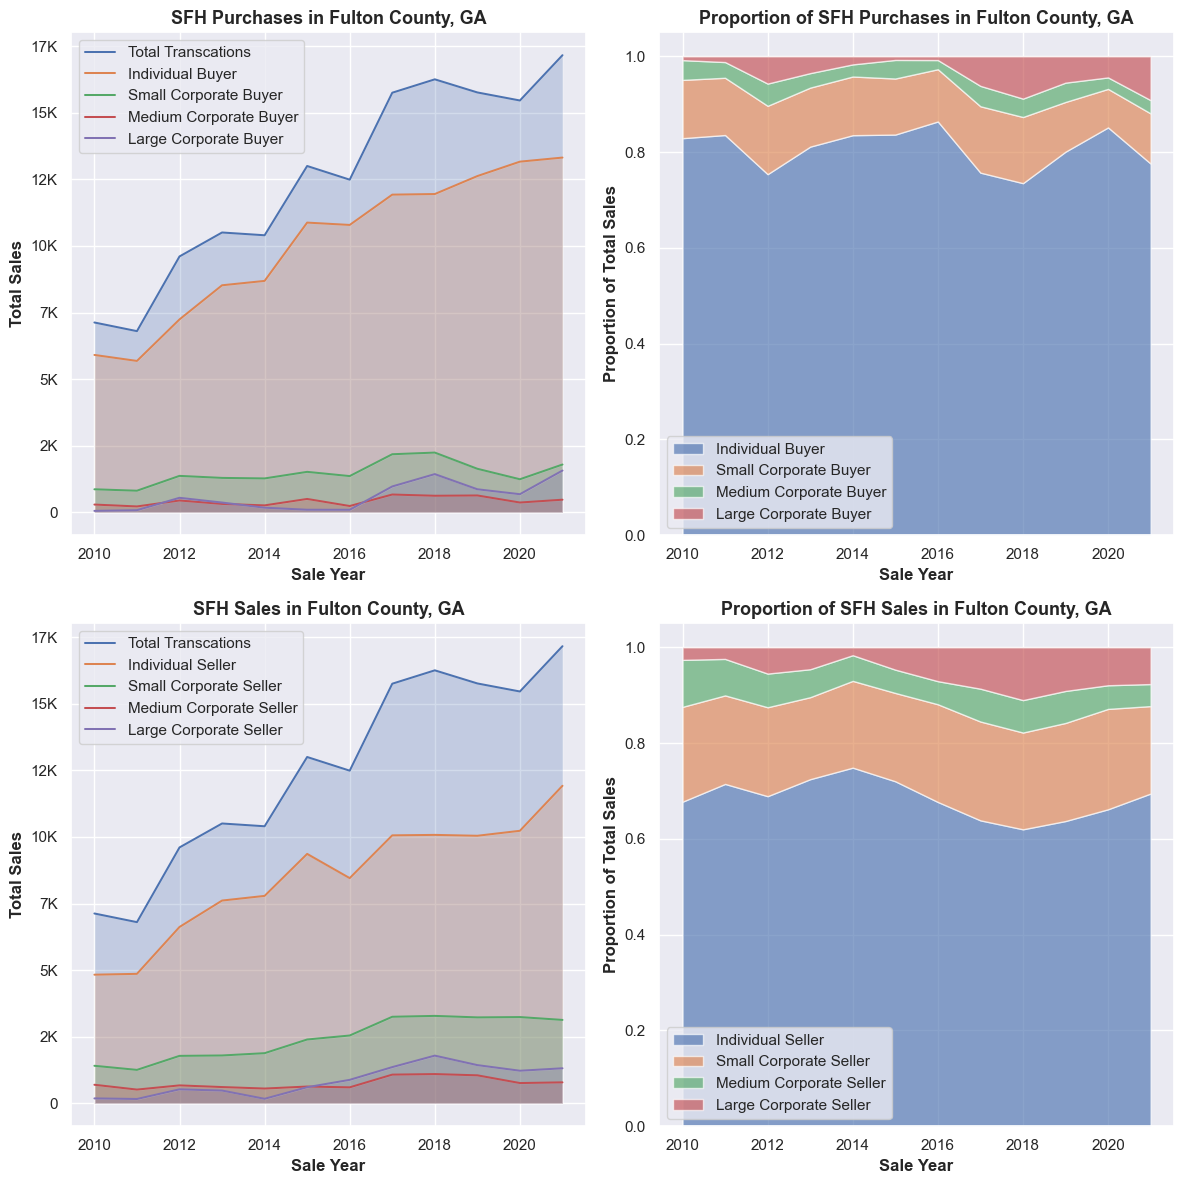

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

utils.area_plot(
    df=total_sales,
    x="Sale Year",
    cols=["Total Fulton", "Individual Buyer Fulton", "Small Corporate Buyer Fulton",
    "Medium Corporate Buyer Fulton", "Large Corporate Buyer Fulton"],
    labels=["Total Transcations", "Individual Buyer", "Small Corporate Buyer",
    "Medium Corporate Buyer", "Large Corporate Buyer"],
    x_label="Sale Year",
    y_label=f"Total Sales",
    title=f"SFH Purchases in Fulton County, GA",
    ax=ax[0][0],
    format_func=format_thousands,
    format_tuple=(0, 1),
    legend={"loc": "upper left"}
)


utils.stacked_plot(
    df=total_sales,
    x="Sale Year",
    cols=["Individual Buyer Fulton %", "Small Corporate Buyer Fulton %",
    "Medium Corporate Buyer Fulton %", "Large Corporate Buyer Fulton %"],
    labels=["Individual Buyer", "Small Corporate Buyer",
    "Medium Corporate Buyer", "Large Corporate Buyer"],
    x_label="Sale Year",
    y_label=f"Proportion of Total Sales",
    title=f"Proportion of SFH Purchases in Fulton County, GA",
    ax=ax[0][1],
    opacity=.65,
    legend={"loc": "lower left"}

)

utils.area_plot(
    df=total_sales,
    x="Sale Year",
    cols=["Total Fulton", "Individual Seller Fulton", "Small Corporate Seller Fulton",
    "Medium Corporate Seller Fulton", "Large Corporate Seller Fulton"],
    labels=["Total Transcations", "Individual Seller", "Small Corporate Seller",
    "Medium Corporate Seller", "Large Corporate Seller"],
    x_label="Sale Year",
    y_label=f"Total Sales",
    title=f"SFH Sales in Fulton County, GA",
    ax=ax[1][0],
    format_func=format_thousands,
    format_tuple=(0, 1),
    legend={"loc": "upper left"}
)

utils.stacked_plot(
    df=total_sales,
    x="Sale Year",
    cols=["Individual Seller Fulton %", "Small Corporate Seller Fulton %",
    "Medium Corporate Seller Fulton %", "Large Corporate Seller Fulton %"],
    labels=["Individual Seller", "Small Corporate Seller",
    "Medium Corporate Seller", "Large Corporate Seller"],
    x_label="Sale Year",
    y_label=f"Proportion of Total Sales",
    title=f"Proportion of SFH Sales in Fulton County, GA",
    ax=ax[1][1],
    opacity=.65,
    legend={"loc": "lower left"}
)

plt.tight_layout()

## Figure 4. Ownership of SFH Rentals

In [ ]:
owner_scale = pd.read_csv("output/owner_scale.csv")
owner_scale.head(2)

,TAXYR,owner_addr,count_owned_fulton_yr,assoc_owner_names
0,2010,0 54541 30308,1,['MARSH ADRIAN S']
1,2010,0 99 - 22 215TH 11429,1,"['COKLEY JEREL &', 'COKLEY JEREL &']"


In [ ]:
digest = digest.merge(
    owner_scale[["TAXYR", "owner_addr", "count_owned_fulton_yr"]],
    on=["TAXYR", "owner_addr"],
    how="left"
)

digest["owner scale"] = digest[digest["own_corp_flag"] == 1]["count_owned_fulton_yr"].apply(classify_corp)
digest["owner scale"] = digest["owner scale"].fillna(0).astype(int)

In [ ]:
rentals = digest[digest["rental_flag"] == 1]

total_fulton_yr = pd.DataFrame(rentals.groupby("TAXYR")["PARID"].count()).rename(columns={"PARID": "Total Fulton"}).reset_index()

total_atl_yr = pd.DataFrame(rentals[
    (rentals["neighborhood"].notna())
].groupby("TAXYR")["PARID"].count()).rename(columns={"PARID": "Total Atlanta"}).reset_index()

names = {
    0: "Individual",
    1: "Small Corporate",
    2: "Medium Corporate",
    3: "Large Corporate"
}

dfs = [total_fulton_yr] + [total_atl_yr] + []

for i in range(4): 
    dfs.append(pd.DataFrame(
        rentals[rentals["owner scale"] == i].groupby("TAXYR")["PARID"].count()
    ).rename(columns={"PARID": f"{names[i]} Fulton"}).reset_index())
    
    dfs.append(pd.DataFrame(
        rentals[
            (rentals["owner scale"] == i)
            & (rentals["neighborhood"].notna())
        ].groupby("TAXYR")["PARID"].count()
    ).rename(columns={"PARID": f"{names[i]} Atlanta"}).reset_index())

rental_summary = reduce(lambda left, right: pd.merge(left, right, on='TAXYR'), dfs)

In [ ]:
dfs = [rental_summary] + []
for area in ["Fulton", "Atlanta"]:
    dfs.append(rental_summary[
        [f"Individual {area}", f"Small Corporate {area}", f"Medium Corporate {area}", f"Large Corporate {area}"]
    ].divide(rental_summary[f"Total {area}"], axis=0).rename(columns={
        f"Individual {area}": f"Individual {area} %",
        f"Small Corporate {area}": f"Small Corporate {area} %",
        f"Medium Corporate {area}": f"Medium Corporate {area} %",
        f"Large Corporate {area}": f"Large Corporate {area} %",
    }))

rental_summary = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True), dfs)
rental_summary

,TAXYR,Total Fulton,Total Atlanta,Individual Fulton,Individual Atlanta,Small Corporate Fulton,Small Corporate Atlanta,Medium Corporate Fulton,Medium Corporate Atlanta,Large Corporate Fulton,Large Corporate Atlanta,Individual Fulton %,Small Corporate Fulton %,Medium Corporate Fulton %,Large Corporate Fulton %,Individual Atlanta %,Small Corporate Atlanta %,Medium Corporate Atlanta %,Large Corporate Atlanta %
0,2010,38150,21247,28683,15403,5652,3389,2457,1578,1358,877,0.75185,0.14815,0.06440,0.03560,0.72495,0.15950,0.07427,0.04128
1,2011,39521,21835,29339,15485,6030,3653,2630,1772,1522,925,0.74236,0.15258,0.06655,0.03851,0.70918,0.16730,0.08115,0.04236
2,2012,40034,21961,29559,15427,6464,3898,2761,1914,1250,722,0.73835,0.16146,0.06897,0.03122,0.70247,0.17750,0.08715,0.03288
3,2013,41220,22274,29697,15290,6963,4142,2933,1863,1627,979,0.72045,0.16892,0.07115,0.03947,0.68645,0.18596,0.08364,0.04395
4,2014,42374,22560,29333,15045,7295,4219,3231,2092,2515,1204,0.69224,0.17216,0.07625,0.05935,0.66689,0.18701,0.09273,0.05337
5,2015,42970,22563,28684,14686,7698,4409,3467,2016,3121,1452,0.66754,0.17915,0.08068,0.07263,0.65089,0.19541,0.08935,0.06435
6,2016,39581,22721,25751,14488,7414,4762,3587,2263,2829,1208,0.65059,0.18731,0.09062,0.07147,0.63765,0.20959,0.09960,0.05317
7,2017,43282,22615,27730,14157,8477,4964,3976,2200,3099,1294,0.64068,0.19586,0.09186,0.07160,0.62600,0.21950,0.09728,0.05722
8,2018,42716,22255,26475,13336,8897,5338,3408,1979,3936,1602,0.61979,0.20828,0.07978,0.09214,0.59924,0.23986,0.08892,0.07198
9,2019,42930,22171,25449,12628,9334,5735,3853,2336,4294,1472,0.59280,0.21742,0.08975,0.10002,0.56957,0.25867,0.10536,0.06639


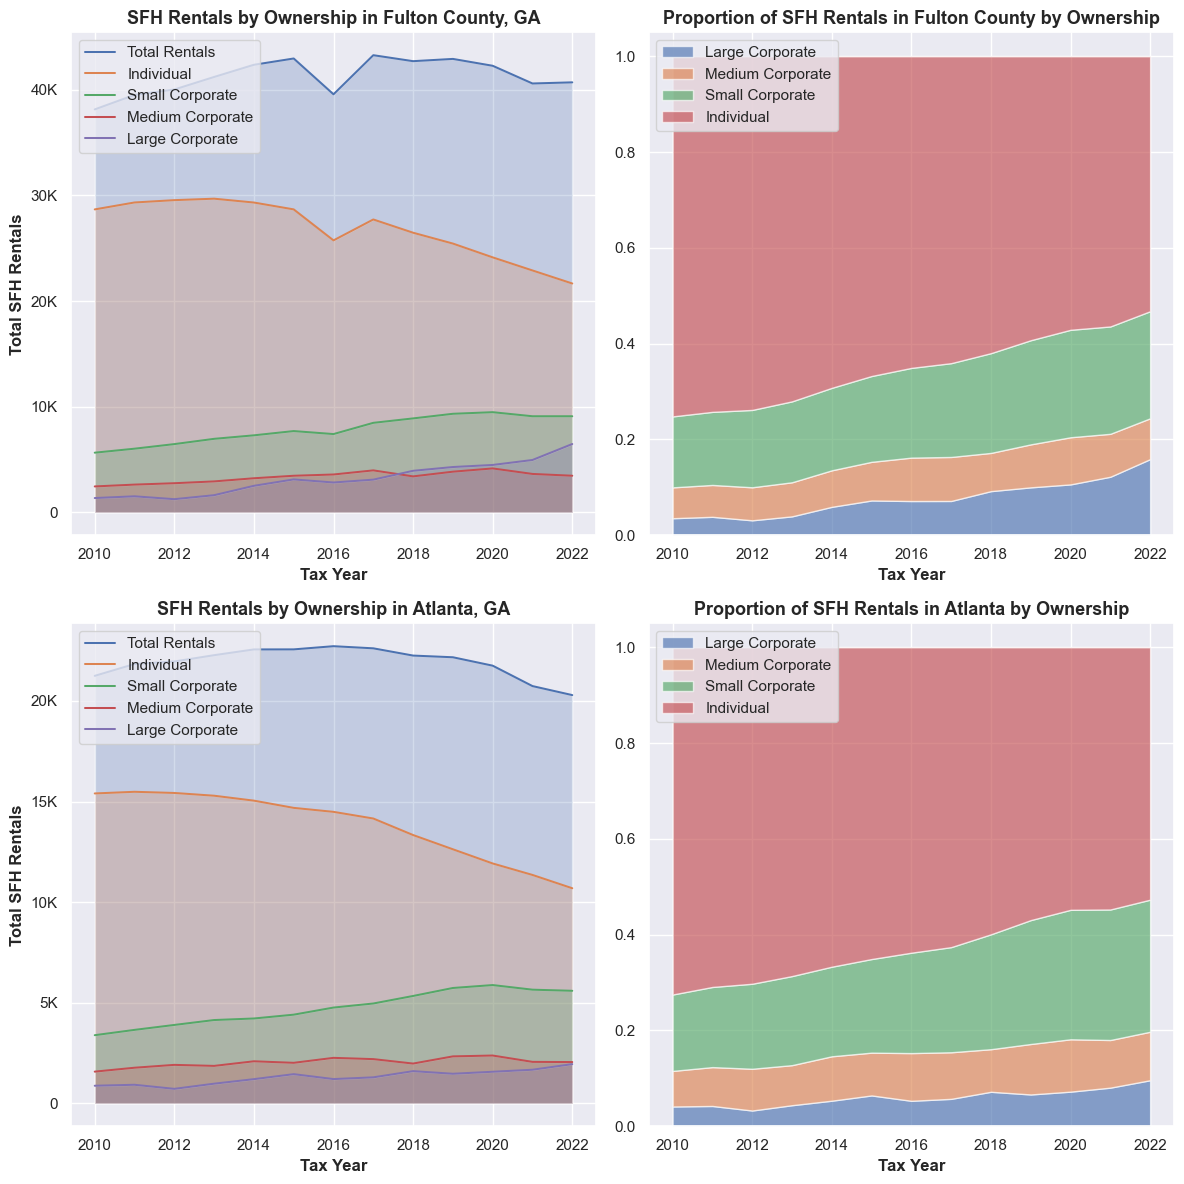

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

for i, area in enumerate(["Fulton", "Atlanta"]):
    if area == "Fulton":
        note = " County"
    else:
        note = ""
    utils.area_plot(
        rental_summary,
        "TAXYR",
        [f"Total {area}", f"Individual {area}", f"Small Corporate {area}", f"Medium Corporate {area}", f"Large Corporate {area}"],
        [f"Total Rentals", f"Individual", f"Small Corporate", f"Medium Corporate", f"Large Corporate"],
        "Tax Year",
        "Total SFH Rentals",
        f"SFH Rentals by Ownership in {area}{note}, GA",
        legend={"loc": "upper left"},
        ax=ax[i][0],
        format_func=format_thousands,
        format_tuple=(0, 1)
    )

    utils.stacked_plot(
        rental_summary,
        "TAXYR",
        reversed(
            [f"Individual {area} %", f"Small Corporate {area} %",
             f"Medium Corporate {area} %", f"Large Corporate {area} %"]),
        reversed([f"Individual", f"Small Corporate", f"Medium Corporate", f"Large Corporate"]),
        "Tax Year",
        title=f"Proportion of SFH Rentals in {area}{note} by Ownership",
        legend={"loc": "upper left"},
        ax=ax[i][1],
        opacity=.65
    )

plt.tight_layout()

## Figure 5. Neighborhood characteristics

In [ ]:
nsa_geo.rename(columns={"NEIGHBORHO": "neighborhood"}, inplace=True)
nsa_geo = nsa_geo[['neighborhood', 'geometry']]

nsa_stats.rename(columns={"Details": "neighborhood"}, inplace=True)
nsa_stats = nsa_stats[[
    "neighborhood",
    "Median household income 2021",
    "% Not Hispanic Black or African American alone 2021",
]]

In [ ]:
nsa_geo = nsa_geo.merge(
    nsa_stats,
    on="neighborhood",
    how="left"
)

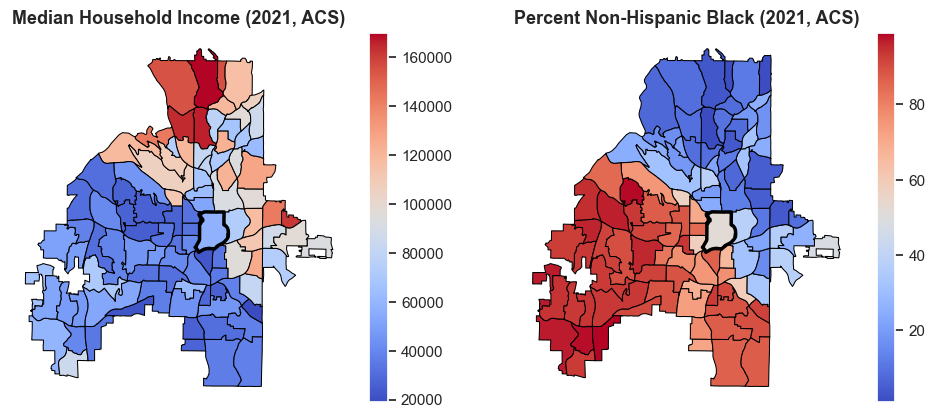

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
hues = [
    "Median household income 2021",
    "% Not Hispanic Black or African American alone 2021",
]
titles = [
    "Median Household Income (2021, ACS)",
    "Percent Non-Hispanic Black (2021, ACS)",
]

for i, ax in enumerate(axes.flatten()):
    utils.map(
        nsa_geo,
        color=hues[i],
        title=titles[i],
        nbhd_df=nsa_geo,
        ax=ax,
        highlight=["Castleberry Hill, Downtown"],
    )

## Figure 6. Sales per SFH Parcel, Proportion Valid SFH Sales by Neighborhood

In [ ]:
atl_sales = sales[
    sales["neighborhood"].notna()
]
atl_valid_sales = valid_sales[
    valid_sales["neighborhood"].notna()
]
atl_parcels = digest[
    digest["neighborhood"].notna()
]

atl_sales_summary = atl_sales.groupby("neighborhood")["PARID"].count().rename("Total Sales").reset_index().merge(
    atl_parcels[atl_parcels["TAXYR"] == 2022].groupby("neighborhood")["PARID"].count().rename("Total Parcels 2022").reset_index(),
    on="neighborhood",
    how="left"
).merge(
    atl_valid_sales.groupby("neighborhood")["PARID"].count().rename("Valid Sales").reset_index(),
    on="neighborhood",
    how="left"
).merge(
    nsa_geo[["neighborhood", "geometry"]],
    on="neighborhood",
    how="left"
)

atl_sales_summary["Sales Per Parcel"] = atl_sales_summary["Total Sales"].divide(atl_sales_summary["Total Parcels 2022"], axis=0)
atl_sales_summary["Percent Valid Sales"] = atl_sales_summary["Valid Sales"].divide(atl_sales_summary["Total Sales"], axis=0)
atl_sales_summary["Percent Invalid Sales"] = 1 - atl_sales_summary["Percent Valid Sales"]
atl_sales_summary.sort_values("Sales Per Parcel", ascending=False).head(5)

,neighborhood,Total Sales,Total Parcels 2022,Valid Sales,geometry,Sales Per Parcel,Percent Valid Sales,Percent Invalid Sales
70,Lindbergh/Morosgo,88,61,72,"POLYGON ((-84.37344 33.81581, -84.37316 33.815...",1.44262,0.81818,0.18182
24,"Berkeley Park, Blandtown, Hills Park",1106,983,943,"POLYGON ((-84.40828 33.78821, -84.40767 33.788...",1.12513,0.85262,0.14738
48,"Collier Hills, Collier Hills North, Colonial H...",441,405,395,"POLYGON ((-84.38923 33.81761, -84.38916 33.817...",1.08889,0.89569,0.10431
0,"Adair Park, Pittsburgh",1712,1592,831,"POLYGON ((-84.40535 33.74403, -84.40447 33.744...",1.07538,0.48540,0.51460
33,"Buckhead Village, Peachtree Park",533,510,477,"POLYGON ((-84.38034 33.83709, -84.37974 33.837...",1.04510,0.89493,0.10507


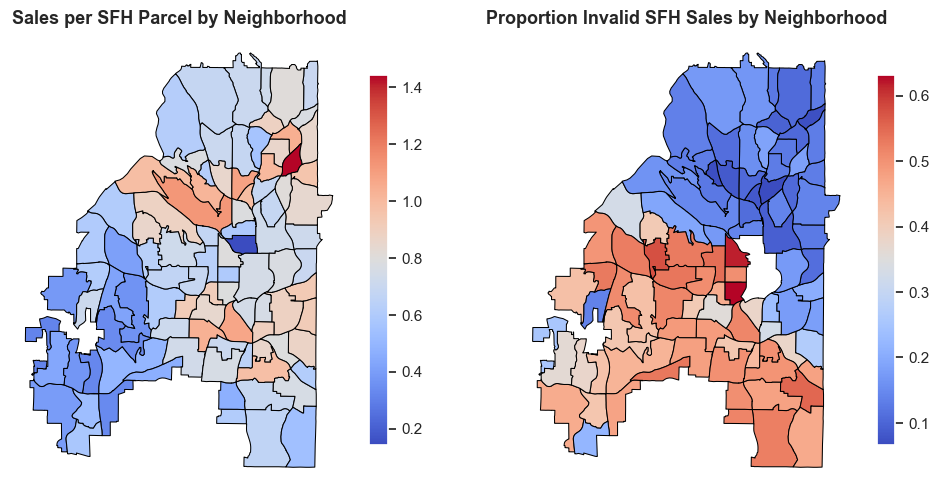

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

atl_sales_summary = atl_sales_summary.fillna(0)
#outliers_1 = ["Georgia Tech, Marietta Street Artery", "Lindbergh/Morosgo"]
utils.map(
    atl_sales_summary,
    color="Sales Per Parcel",
    title="Sales per SFH Parcel by Neighborhood",
    nbhd_df=nsa_geo,
    ax=ax[0]
)

utils.map(
    atl_sales_summary,
    color="Percent Invalid Sales",
    title="Proportion Invalid SFH Sales by Neighborhood",
    nbhd_df=nsa_geo,
    ax=ax[1]
)

## Figure 7. Percent of Sales at each Transaction Scale by Neighborhood

In [ ]:
atl_digest_2022 = digest[
    (digest["neighborhood"].notna())
    & (digest["TAXYR"] == 2022)
]

dfs = [] + [
    pd.DataFrame(
        atl_digest_2022.groupby("neighborhood")["PARID"].count().rename("Total Parcels")
    )
]

for i in range(4):
    dfs.append(pd.DataFrame(
        atl_digest_2022[
            atl_digest_2022["owner scale"] == i
        ].groupby("neighborhood")["PARID"].count()
    ).rename(columns={"PARID": f"{names[i]}"}).reset_index())
    

ownership_2022 = reduce(lambda left, right: pd.merge(left, right, on="neighborhood", how="left"), dfs)

ownership_2022 = ownership_2022.fillna(0)
ownership_2022["Percent Individual"] = ownership_2022["Individual"] / ownership_2022["Total Parcels"] * 100
ownership_2022["Percent Small Corporate"] = ownership_2022["Small Corporate"] / ownership_2022["Total Parcels"] * 100
ownership_2022["Percent Medium Corporate"] = ownership_2022["Medium Corporate"] / ownership_2022["Total Parcels"] * 100
ownership_2022["Percent Large Corporate"] = ownership_2022["Large Corporate"] / ownership_2022["Total Parcels"] * 100

ownership_2022 = ownership_2022.merge(
    nsa_geo[["neighborhood", "geometry"]],
    on="neighborhood",
    how="left"
)

ownership_2022.sort_values(by="Percent Large Corporate", ascending=False).head(5)

,neighborhood,Total Parcels,Individual,Small Corporate,Medium Corporate,Large Corporate,Percent Individual,Percent Small Corporate,Percent Medium Corporate,Percent Large Corporate,geometry
18,"Bankhead, Washington Park",893,576,158.00000,71.00000,88.00000,64.50168,17.69317,7.95073,9.85442,"POLYGON ((-84.41751 33.76043, -84.41749 33.762..."
88,South River Gardens,608,478,47.00000,26.00000,57.00000,78.61842,7.73026,4.27632,9.37500,"POLYGON ((-84.34953 33.67601, -84.34943 33.678..."
21,"Ben Hill Forest, Ben Hill Pines, Brentwood, De...",737,608,49.00000,16.00000,64.00000,82.49661,6.64858,2.17096,8.68385,"POLYGON ((-84.50837 33.69009, -84.50841 33.690..."
2,"Adamsville, Oakcliff",591,455,56.00000,31.00000,49.00000,76.98816,9.47547,5.24535,8.29103,"POLYGON ((-84.50829 33.74873, -84.50820 33.748..."
16,"Baker Hills, Bakers Ferry, Boulder Park, Fairb...",1672,1385,112.00000,38.00000,137.00000,82.83493,6.69856,2.27273,8.19378,"POLYGON ((-84.51374 33.74547, -84.51356 33.746..."


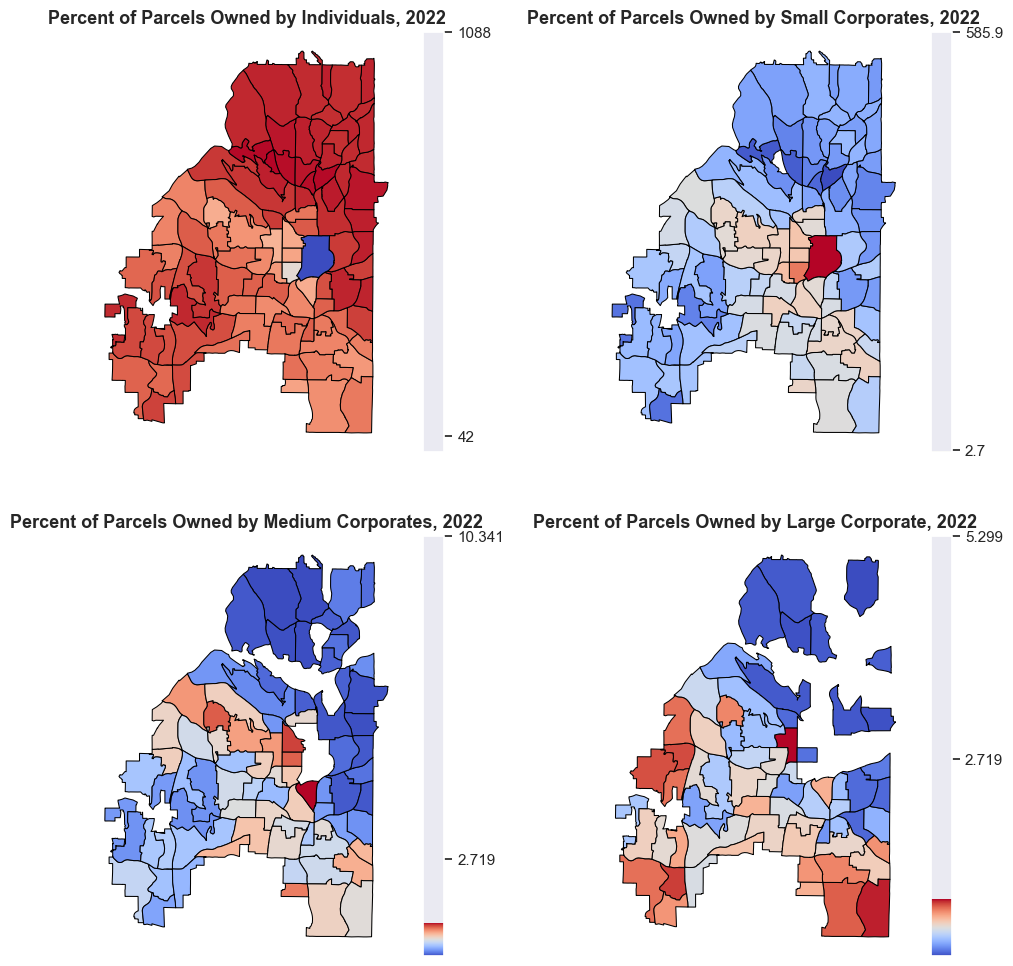

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

utils.map(
    ownership_2022,
    color="Percent Individual",
    title="Percent of Parcels Owned by Individuals, 2022",
    nbhd_df=nsa_geo,
    ax=ax[0][0],
    log=True
)

utils.map(
    ownership_2022,
    color="Percent Small Corporate",
    title="Percent of Parcels Owned by Small Corporates, 2022",
    nbhd_df=nsa_geo,
    ax=ax[0][1],
    log=True
)

utils.map(
    ownership_2022,
    color="Percent Medium Corporate",
    title="Percent of Parcels Owned by Medium Corporates, 2022",
    nbhd_df=nsa_geo,
    ax=ax[1][0],
    log=True
)

utils.map(
    ownership_2022,
    color="Percent Large Corporate",
    title="Percent of Parcels Owned by Large Corporate, 2022",
    nbhd_df=nsa_geo,
    ax=ax[1][1],
    log=True
)

## Figure 8. Percent of Sales by Sale Type Map

In [ ]:
dfs = [] + [atl_sales_summary]

sale_types = ["corp_bought_ind", "corp_sold_ind", "ind_to_ind", "corp_to_corp"]
for sale in sale_types:
    dfs.append(pd.DataFrame(atl_sales[
        atl_sales[sale] == 1
    ].groupby("neighborhood")["PARID"].count()).rename(columns={"PARID": f"Total {sale}"}).reset_index())
    
atl_sales_summary = reduce(lambda left, right: pd.merge(left, right, on="neighborhood", how="left"), dfs)

atl_sales_summary = atl_sales_summary.fillna(0)
atl_sales_summary['Percent corp_bought_ind'] = atl_sales_summary['Total corp_bought_ind'] / atl_sales_summary['Total Sales']
atl_sales_summary['Percent corp_sold_ind'] = atl_sales_summary['Total corp_sold_ind'] / atl_sales_summary['Total Sales']
atl_sales_summary['Percent ind_to_ind'] = atl_sales_summary['Total ind_to_ind'] / atl_sales_summary['Total Sales']
atl_sales_summary['Percent corp_to_corp'] = atl_sales_summary['Total corp_to_corp'] / atl_sales_summary['Total Sales']
atl_sales_summary.sort_values(by="Percent corp_bought_ind", ascending=False).head(5)

,neighborhood,Total Sales,Total Parcels 2022,Valid Sales,geometry,Sales Per Parcel,Percent Valid Sales,Percent Invalid Sales,Total corp_bought_ind,Total corp_sold_ind,Total ind_to_ind,Total corp_to_corp,Percent corp_bought_ind,Percent corp_sold_ind,Percent ind_to_ind,Percent corp_to_corp
61,Hammond Park,247,407,119,"POLYGON ((-84.41657 33.67310, -84.41427 33.673...",0.60688,0.48178,0.51822,79.00000,71.00000,66.00000,31.00000,0.31984,0.28745,0.26721,0.12551
83,Perkerson,226,480,112,"POLYGON ((-84.41669 33.68137, -84.41596 33.681...",0.47083,0.49558,0.50442,60.00000,46.00000,71.00000,49.00000,0.26549,0.20354,0.31416,0.21681
17,"Bankhead Courts, Bankhead/Bolton, Carroll Heig...",585,975,295,"POLYGON ((-84.51545 33.76516, -84.51535 33.765...",0.60000,0.50427,0.49573,148.00000,128.00000,143.00000,166.00000,0.25299,0.21880,0.24444,0.28376
18,"Bankhead, Washington Park",564,893,257,"POLYGON ((-84.41751 33.76043, -84.41749 33.762...",0.63158,0.45567,0.54433,142.00000,154.00000,135.00000,133.00000,0.25177,0.27305,0.23936,0.23582
25,"Blair Villa/Poole Creek, Glenrose Heights, Orc...",779,1178,371,"POLYGON ((-84.39123 33.64812, -84.39122 33.648...",0.66129,0.47625,0.52375,191.00000,209.00000,169.00000,210.00000,0.24519,0.26829,0.21694,0.26958


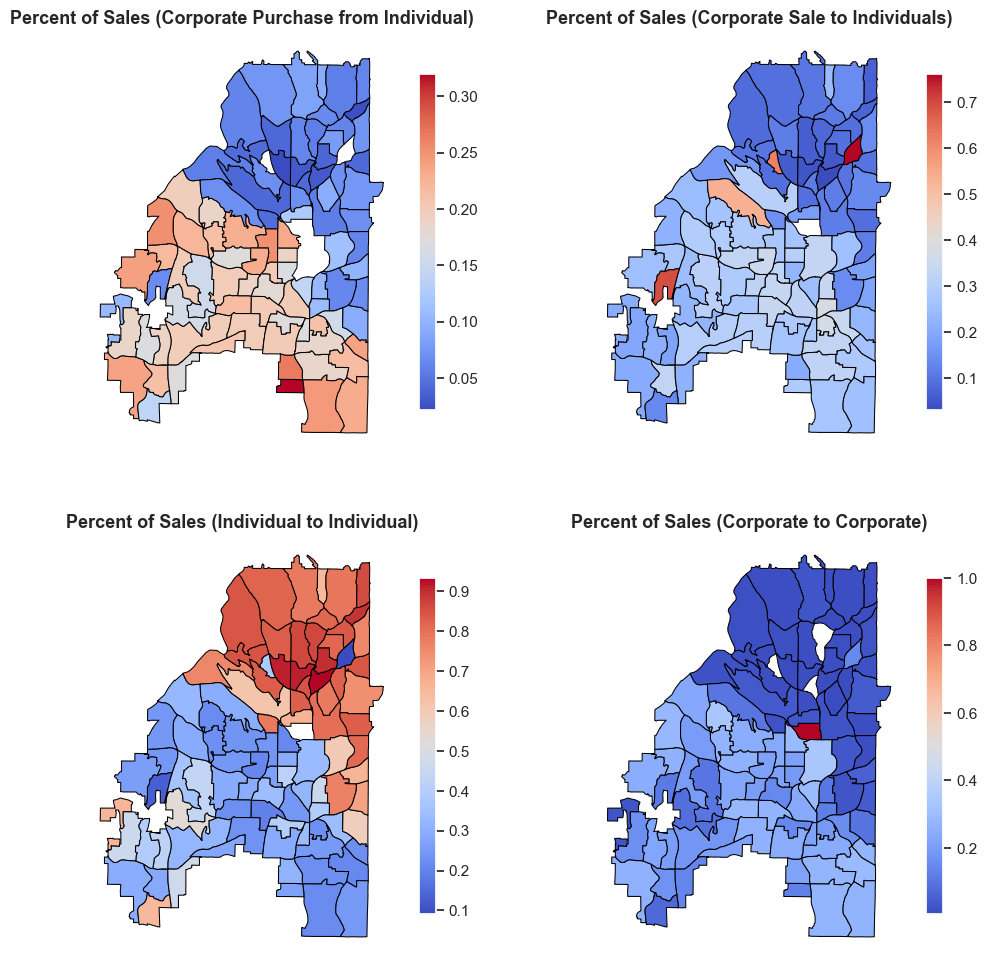

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

utils.map(
    atl_sales_summary,
    color="Percent corp_bought_ind",
    title="Percent of Sales (Corporate Purchase from Individual)",
    nbhd_df=nsa_geo,
    ax=ax[0][0]
)
utils.map(
    atl_sales_summary,
    color="Percent corp_sold_ind",
    title="Percent of Sales (Corporate Sale to Individuals)",
    nbhd_df=nsa_geo,
    ax=ax[0][1]
)
utils.map(
    atl_sales_summary,
    color="Percent ind_to_ind",
    title="Percent of Sales (Individual to Individual)",
    nbhd_df=nsa_geo,
    ax=ax[1][0]
)
utils.map(
    atl_sales_summary,
    color="Percent corp_to_corp",
    title="Percent of Sales (Corporate to Corporate)",
    nbhd_df=nsa_geo,
    ax=ax[1][1]
)

## Figure 9. Graph of Majority-Black vs Other Neighborhoods by Corporate Purchases and Sales

In [ ]:
# Separate neighborhoods into majority Black and other with mb_flag
mb_neighborhoods = nsa_geo[
    nsa_geo["% Not Hispanic Black or African American alone 2021"] >= 50
]["neighborhood"].unique()

sales["mb_flag"] = sales["neighborhood"].apply(lambda x: 1 if x in mb_neighborhoods else 0)
# Agg all sales on mb_flag, calculate total transcations, number where buyer is corp,
# seller is corp, buyer is corp and seller is corp, then calculate percent
total = sales.groupby(by=["mb_flag", "Sale Year"])["PARID"].count().rename("total")

corp_trans = sales[
    (sales["GRANTEE_corp_flag"] == 1)
    | (sales["GRANTOR_corp_flag"] == 1)
].groupby(by=["mb_flag", "Sale Year"])["PARID"].count().rename("corp_trans")

mb_summary = pd.concat([total, corp_trans], axis=1).reset_index()

mb_summary["% corp"] = mb_summary["corp_trans"] / mb_summary["total"]

mb_summary

,mb_flag,Sale Year,total,corp_trans,% corp
0,0,2010,5613,1829,0.32585
1,0,2011,5522,1598,0.28939
2,0,2012,7910,3059,0.38673
3,0,2013,8746,2617,0.29922
4,0,2014,8756,2458,0.28072
5,0,2015,10778,3497,0.32446
6,0,2016,10310,3457,0.33531
7,0,2017,12157,4816,0.39615
8,0,2018,12279,5199,0.42341
9,0,2019,12414,4949,0.39866


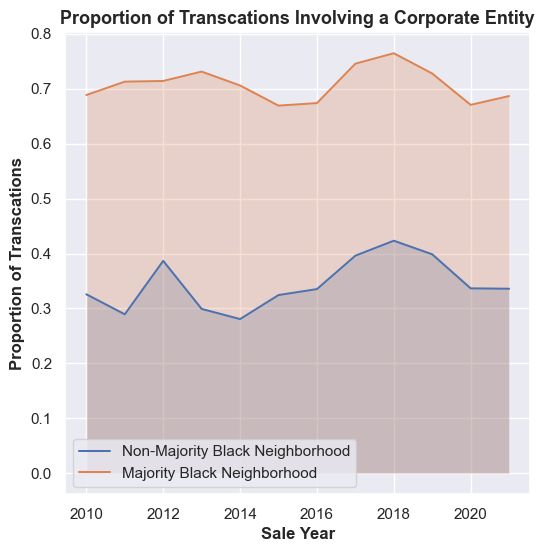

In [ ]:
# add in corp to corp / invalid
# for each point, put absolute numbers

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

utils.area_plot(
    mb_summary[mb_summary["mb_flag"] == 0],
    "Sale Year",
    ["% corp"],
    ["Non-Majority Black Neighborhood"],
    "Sale Year",
    title="Proportion of Transcations Involving a Corporate Entity",
    ax=ax,
    legend={"loc": "lower left"}
)

utils.area_plot(
    mb_summary[mb_summary["mb_flag"] == 1],
    "Sale Year",
    ["% corp"],
    ["Majority Black Neighborhood"],
    "Sale Year",
    "Proportion of Transcations",
    ax=ax,
    legend={"loc": "lower left"}
)

---
## Equity Loss Figures

## Calculation
Drop outliers where sale_diff is too extreme (multi-parcel sales with properties outside Fulton most likely)

In [ ]:
# sale_diff = fmv_adj - price_adj
sales["sale_diff"] = sales["fmv_adj"] - sales["price_adj"]
original_sales = sales.copy(deep=True)

# Calculate the 99th percentile of sale_diff
top_threshold = sales["sale_diff"].quantile(0.99)
bottom_threshold = sales["sale_diff"].quantile(0.01)

# Filter out the rows where sale_diff is greater than the threshold
sales = sales[
    (sales["sale_diff"] < top_threshold)
    & (sales["sale_diff"] > bottom_threshold)
]
dropped_sales = original_sales[(original_sales["sale_diff"] >= top_threshold) | (original_sales["sale_diff"] <= bottom_threshold)]

# sale loss: aggregate sale_diff where corp_sold_ind = 1
# positive indicates sold for below FMV, company contributed to neighborhood equity
# flip sign so negative is contributing, positive is loss
sale_loss = sales[
    (sales["neighborhood"].notna())
    & (sales["corp_sold_ind"] == 1)
].groupby(
    by=["TAXYR", "neighborhood"]
)["sale_diff"].sum().rename("sale_loss").reset_index()

sale_loss["sale_loss"] = -sale_loss["sale_loss"]

# purchase loss: aggregate sale_diff where corp_bought_ind = 1
# positive indicates company bought for below FMV, company extracted equity
purchase_loss = sales[
    (sales["neighborhood"].notna())
    & (sales["corp_bought_ind"] == 1)
].groupby(
    by=["TAXYR", "neighborhood"]
)["sale_diff"].sum().rename("purchase_loss").reset_index()

# rental loss: sum of aprtot_adj where rental_flag = 1 and own_corp_flag = 1
digest["rental_value"] = digest["Aprtot_adj"] * .005 * 12

# we don't want to look at 2022 rental loss, since sale data stops at 2021
rental_loss = digest[
    (digest["neighborhood"].notna())
    & (digest["rental_flag"] == 1)
    & (digest["own_corp_flag"] == 1)
    & (digest["TAXYR"] < 2022)
].groupby(by=["TAXYR", "neighborhood"])["rental_value"].sum().rename("rental_loss").reset_index()

equity_summary = pd.DataFrame(sale_loss).merge(
    pd.DataFrame(purchase_loss),
    on=["TAXYR", "neighborhood"],
    how="outer"
).merge(
    pd.DataFrame(rental_loss),
    on=["TAXYR", "neighborhood"],
    how="outer"
).fillna(0)

equity_summary["total_loss"] = equity_summary["sale_loss"] + equity_summary["purchase_loss"] + equity_summary["rental_loss"]

equity_summary = equity_summary.merge(
    nsa_geo,
    on="neighborhood",
    how="left"
)
equity_summary.head(3)

,TAXYR,neighborhood,sale_loss,purchase_loss,rental_loss,total_loss,geometry,Median household income 2021,% Not Hispanic Black or African American alone 2021
0,2011,"Adair Park, Pittsburgh","710,727.65467","284,190.94648","1,022,765.99718","2,017,684.59832","POLYGON ((-84.40535 33.74403, -84.40447 33.744...","39,353.00000",75.20000
1,2011,"Adams Park, Laurens Valley, Southwest","191,609.48585","-33,113.91072","427,316.02955","585,811.60468","POLYGON ((-84.47248 33.70263, -84.47117 33.702...","53,069.00000",93.60000
2,2011,"Adamsville, Oakcliff","-82,940.50183","51,924.13947","269,612.44015","238,596.07780","POLYGON ((-84.50829 33.74873, -84.50820 33.748...","38,142.00000",96.00000


In [ ]:
equity_summary.tail(3)

,TAXYR,neighborhood,sale_loss,purchase_loss,rental_loss,total_loss,geometry,Median household income 2021,% Not Hispanic Black or African American alone 2021
1220,2021,"Georgia Tech, Marietta Street Artery",0.00000,0.00000,"68,101.00962","68,101.00962","POLYGON ((-84.40728 33.77307, -84.40714 33.772...","52,268.00000",24.00000
1221,2021,Knight Park/Howell Station,0.00000,0.00000,"389,763.62868","389,763.62868","POLYGON ((-84.42228 33.77561, -84.41953 33.775...","112,083.00000",57.20000
1222,2021,Piedmont Heights,0.00000,0.00000,"251,415.48871","251,415.48871","POLYGON ((-84.37698 33.81170, -84.37707 33.811...","93,476.00000",32.20000


In [ ]:
sales.sample(3)[["TAXYR", "neighborhood", "fmv_adj", "price_adj", "sale_diff"]]

,TAXYR,neighborhood,fmv_adj,price_adj,sale_diff
28877,2018,NaN,"530,089.23715","559,826.24410","-29,737.00694"
130670,2014,"Grant Park, Oakland","250,377.77549","375,694.01714","-125,316.24165"
2269,2013,"Browns Mill Park, Polar Rock, Swallow Circle/B...","27,016.68242","2,834.62799","24,182.05443"


In [ ]:
digest.sample(3)[["TAXYR", "neighborhood", "rental_flag", "own_corp_flag", "Aprtot_adj", "rental_value"]]

,TAXYR,neighborhood,rental_flag,own_corp_flag,Aprtot_adj,rental_value
2028508,2014,NaN,0,0,"442,012.80556","26,520.76833"
2511044,2010,NaN,0,0,"937,058.40432","56,223.50426"
1229741,2022,"Grant Park, Oakland",0,0,"463,400.00000","27,804.00000"


In [ ]:
household_data = pd.read_csv("data/atl_nsa_households.csv", skiprows=1).rename(columns={"Details": "neighborhood"})
household_data.head(2)

,GEOID,neighborhood,Average household size 2021,Median household income 2021,# Age 18 years and over 2021,# Age 21 years and over 2021,# Total households 2021
0,A01,"Margaret Mitchell, Paces, Pleasant Hill",2.40000,NaN,2981,2930,1660
1,A02,"Kingswood, Mt. Paran/Northside, Mt. Paran Park...",2.20000,"154,720.00000",3555,3496,2019


In [ ]:
total_sale_loss = sale_loss.groupby(by=["neighborhood"])["sale_loss"].sum().rename("sale_loss").reset_index()
total_purchase_loss = purchase_loss.groupby(by=["neighborhood"])["purchase_loss"].sum().rename("purchase_loss").reset_index()
total_rental_loss = rental_loss.groupby(by=["neighborhood"])["rental_loss"].sum().rename("rental_loss").reset_index()
total_equity_loss = total_sale_loss.merge(
    total_purchase_loss,
    on="neighborhood",
    how="outer"
).merge(
    total_rental_loss,
    on="neighborhood",
    how="outer"
).fillna(0)
total_equity_loss["total_loss"] = total_equity_loss["sale_loss"] + total_equity_loss["purchase_loss"] + total_equity_loss["rental_loss"]

total_equity_loss = total_equity_loss.merge(
    nsa_geo,
    on="neighborhood",
    how="left"
).merge(
    household_data[["neighborhood", "Average household size 2021", "# Total households 2021"]],
    on="neighborhood",
    how="left"
)
total_equity_loss.head(3)

,neighborhood,sale_loss,purchase_loss,rental_loss,total_loss,geometry,Median household income 2021,% Not Hispanic Black or African American alone 2021,Average household size 2021,# Total households 2021
0,"Adair Park, Pittsburgh","10,843,104.76218","7,237,033.94373","19,407,618.47804","37,487,757.18395","POLYGON ((-84.40535 33.74403, -84.40447 33.744...","39,353.00000",75.20000,2.20000,1930
1,"Adams Park, Laurens Valley, Southwest","7,865,043.26129","2,911,128.33078","8,819,599.42904","19,595,771.02111","POLYGON ((-84.47248 33.70263, -84.47117 33.702...","53,069.00000",93.60000,2.40000,3052
2,"Adamsville, Oakcliff","1,518,569.95426","1,208,408.56677","4,688,006.75631","7,414,985.27733","POLYGON ((-84.50829 33.74873, -84.50820 33.748...","38,142.00000",96.00000,3.50000,878


## Figure 10. Purchase, Sale, and Rental Equity Loss Map

In [ ]:
total_equity_loss[total_equity_loss["neighborhood"].str.contains("Lindbergh")]

,neighborhood,sale_loss,purchase_loss,rental_loss,total_loss,geometry,Median household income 2021,% Not Hispanic Black or African American alone 2021,Average household size 2021,# Total households 2021
69,Lindbergh/Morosgo,"2,041,101.33562",0.00000,"1,602,617.35874","3,643,718.69436","POLYGON ((-84.37344 33.81581, -84.37316 33.815...","69,285.00000",32.30000,1.60000,3976


In [ ]:
sales[
    (sales["neighborhood"].notna())
    & (sales["neighborhood"].str.contains("Lindbergh"))
]

,TAXYR,PARID,Luc,Saledt,SALES PRICE,FAIR MARKET VALUE,DEED TYPE,Costval,Saleval,GRANTOR,GRANTEE,M_flag,sale_size,sales_price,price_adj,fmv_adj,count_sales_yr,GRANTEE_exact,GRANTEE_exact_addr,GRANTEE_single_sale,GRANTEE_single_sale_addr,GRANTEE_only_exact_name,GRANTEE_only_exact_name_addr,GRANTOR_exact,GRANTOR_exact_addr,GRANTOR_single_sale,GRANTOR_single_sale_addr,GRANTOR_only_exact_name,GRANTOR_only_exact_name_addr,GRANTEE_match,GRANTEE_match_addr,GRANTOR_match,GRANTOR_match_addr,GRANTEE_corp_flag,GRANTOR_corp_flag,corp_bought_ind,corp_sold_ind,ind_to_ind,corp_to_corp,OBJECTID,geometry,index_right,neighborhood,Sale Year,Buyer Transactions Fulton,Seller Transactions Fulton,Buyer Scale,Seller Scale,mb_flag,sale_diff
2298,2019,17 004800021939,101,26-JUN-2018,"1,969,824.00000","721,100.00000",LW,"721,100",M,LINDBERGH SOLUTIONS LLC,WEEKLEY HOMES LLC,True,3,"656,608.00000","775,691.42818","851,879.79565",1,WEEKLEY HOMES LLC,1111 POST OAK 77055,WEEKLEY HOMES LLC,1111 POST OAK 77055,WEEKLEY HOMES LLC,1111 NORTH POST OAK 77055,<NA>,<NA>,<NA>,<NA>,LINDBERGH SOLUTIONS LLC,90 7TH 55402,WEEKLEY HOMES LLC,1111 POST OAK 77055,LINDBERGH SOLUTIONS LLC,90 7TH 55402,1,1,0,0,0,1,"982,683.00000","POLYGON ((-84.3646001104077 33.8209825858351, ...",7.00000,Lindbergh/Morosgo,2018,10,5,1,1,0,"76,188.36747"
2299,2019,17 004800021921,101,26-JUN-2018,"1,969,824.00000","649,500.00000",LW,"649,500",M,LINDBERGH SOLUTIONS LLC,WEEKLEY HOMES LLC,True,3,"656,608.00000","775,691.42818","767,294.31046",1,WEEKLEY HOMES LLC,1111 POST OAK 77055,WEEKLEY HOMES LLC,1111 POST OAK 77055,WEEKLEY HOMES LLC,1111 NORTH POST OAK 77055,<NA>,<NA>,<NA>,<NA>,LINDBERGH SOLUTIONS LLC,90 7TH 55402,WEEKLEY HOMES LLC,1111 POST OAK 77055,LINDBERGH SOLUTIONS LLC,90 7TH 55402,1,1,0,0,0,1,"982,684.00000","POLYGON ((-84.3645150578114 33.8211836504662, ...",7.00000,Lindbergh/Morosgo,2018,10,5,1,1,0,"-8,397.11772"
2300,2019,17 004800021913,101,26-JUN-2018,"1,969,824.00000","608,100.00000",LW,"608,100",M,LINDBERGH SOLUTIONS LLC,WEEKLEY HOMES LLC,True,3,"656,608.00000","775,691.42818","718,385.94333",1,WEEKLEY HOMES LLC,1111 POST OAK 77055,WEEKLEY HOMES LLC,1111 POST OAK 77055,WEEKLEY HOMES LLC,1111 NORTH POST OAK 77055,<NA>,<NA>,<NA>,<NA>,LINDBERGH SOLUTIONS LLC,90 7TH 55402,WEEKLEY HOMES LLC,1111 POST OAK 77055,LINDBERGH SOLUTIONS LLC,90 7TH 55402,1,1,0,0,0,1,"982,682.00000","POLYGON ((-84.3644335949195 33.8211825882447, ...",7.00000,Lindbergh/Morosgo,2018,10,5,1,1,0,"-57,305.48485"
2302,2019,17 004800021038,101,29-MAR-2018,"519,852.00000","112,500.00000",LW,"580,000",M,LINDBERGH SOLUTIONS LLC,WEEKLEY HOMES LLC,True,2,"259,926.00000","307,066.57574","132,903.17156",1,<NA>,<NA>,<NA>,<NA>,WEEKLEY HOMES LLC,1111 NORTH POST OAK 77055,<NA>,<NA>,<NA>,<NA>,LINDBERGH SOLUTIONS LLC,90 7TH 55402,WEEKLEY HOMES LLC,1111 NORTH POST OAK 77055,LINDBERGH SOLUTIONS LLC,90 7TH 55402,1,1,0,0,0,1,"982,661.00000","POLYGON ((-84.3640431617436 33.8209726235023, ...",7.00000,Lindbergh/Morosgo,2018,14,5,2,1,0,"-174,163.40418"
5379,2018,17 004800021236,101,10-JAN-2017,"863,127.00000","293,100.00000",LW,"293,100",M,LINDBERGH SOLUTIONS LLC,WEEKLEY HOMES LLC,True,5,"172,625.40000","207,828.45015","352,871.12289",1,WEEKLEY HOMES LLC,1111 POST OAK 77055,WEEKLEY HOMES LLC,1111 POST OAK 77055,WEEKLEY HOMES LLC,1111 NORTH POST OAK 77055,<NA>,<NA>,<NA>,<NA>,LINDBERGH SOLUTIONS LLC,90 7TH 55402,WEEKLEY HOMES LLC,1111 POST OAK 77055,LINDBERGH SOLUTIONS LLC,90 7TH 55402,1,1,0,0,0,1,"982,748.00000","POLYGON ((-84.3640997045023 33.8220844533549, ...",7.00000,Lindbergh/Morosgo,2017,6,7,1,1,0,"145,042.67275"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66731,2020,17 004800021897,101,29-MAR-2019,"690,143.00000","677,300.00000",LW,"677,300",0,WEEKLEY HOMES LLC,KUO JUSTIN,False,1,"690,143.00000","797,093.76035","782,260.49367",1,KUO JUSTIN,520 BROADVIEW 30324,KUO JUSTIN,520 BROA

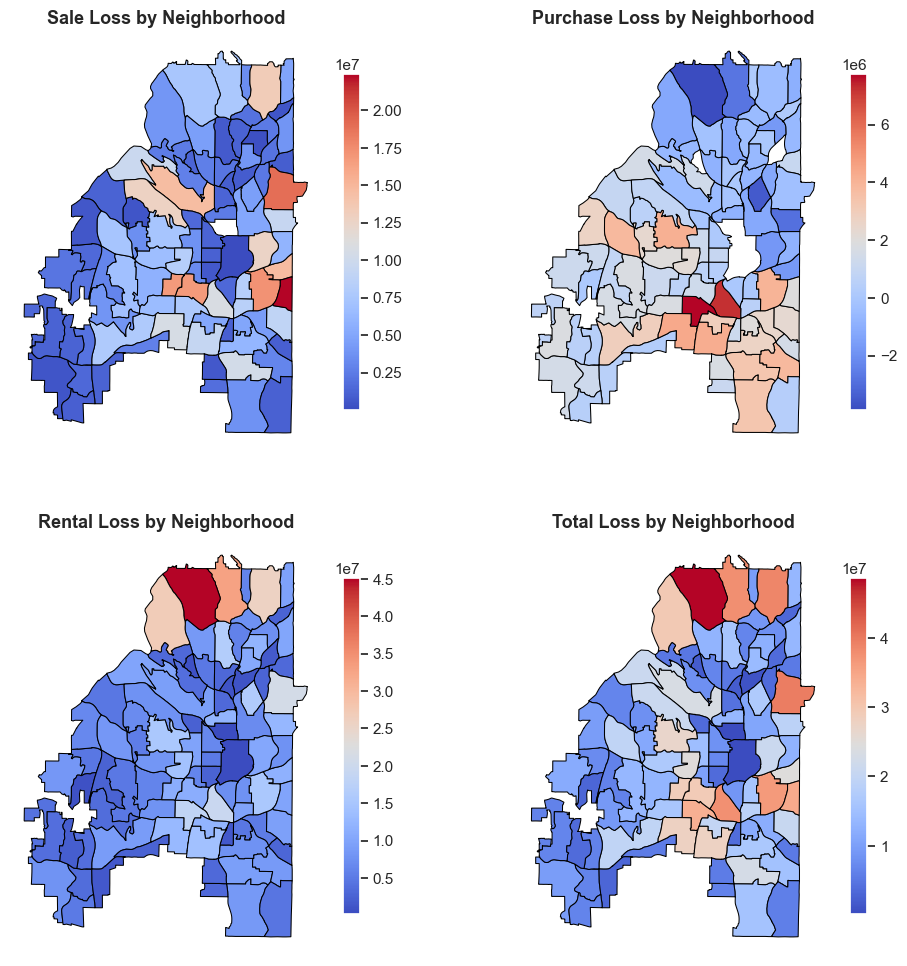

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

names = {
    "sale_loss": "Sale",
    "purchase_loss": "Purchase",
    "rental_loss": "Rental",
    "total_loss": "Total"
}

j = 0
i = 0

for color in ["sale_loss", "purchase_loss", "rental_loss", "total_loss"]:
    utils.map(
        total_equity_loss,
        color=color,
        title=f"{names[color]} Loss by Neighborhood",
        nbhd_df=nsa_geo,
        ax=ax[i][j]
    )
    
    j += 1
    if j == 2:
        j = 0
        i += 1


## Figure 11. Equity Burden Map and Boxplot of Majority-Black vs Other Neighborhoods

In [ ]:
total_equity_loss.head(2)

,neighborhood,sale_loss,purchase_loss,rental_loss,total_loss,geometry,Median household income 2021,% Not Hispanic Black or African American alone 2021,Average household size 2021,# Total households 2021
0,"Adair Park, Pittsburgh","10,843,104.76218","7,237,033.94373","19,407,618.47804","37,487,757.18395","POLYGON ((-84.40535 33.74403, -84.40447 33.744...","39,353.00000",75.20000,2.20000,1930
1,"Adams Park, Laurens Valley, Southwest","7,865,043.26129","2,911,128.33078","8,819,599.42904","19,595,771.02111","POLYGON ((-84.47248 33.70263, -84.47117 33.702...","53,069.00000",93.60000,2.40000,3052


## Change to sum of each year

In [ ]:
total_equity_loss["normalized_loss"] = total_equity_loss["total_loss"] / (
    total_equity_loss["Median household income 2021"] * total_equity_loss["# Total households 2021"]
    * digest["TAXYR"].nunique()
)
total_equity_loss.head(3)

,neighborhood,sale_loss,purchase_loss,rental_loss,total_loss,geometry,Median household income 2021,% Not Hispanic Black or African American alone 2021,Average household size 2021,# Total households 2021,normalized_loss
0,"Adair Park, Pittsburgh","10,843,104.76218","7,237,033.94373","19,407,618.47804","37,487,757.18395","POLYGON ((-84.40535 33.74403, -84.40447 33.744...","39,353.00000",75.20000,2.20000,1930,0.03797
1,"Adams Park, Laurens Valley, Southwest","7,865,043.26129","2,911,128.33078","8,819,599.42904","19,595,771.02111","POLYGON ((-84.47248 33.70263, -84.47117 33.702...","53,069.00000",93.60000,2.40000,3052,0.00931
2,"Adamsville, Oakcliff","1,518,569.95426","1,208,408.56677","4,688,006.75631","7,414,985.27733","POLYGON ((-84.50829 33.74873, -84.50820 33.748...","38,142.00000",96.00000,3.50000,878,0.01703


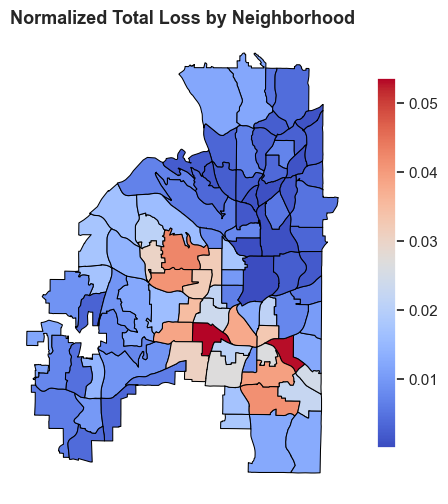

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
utils.map(
    total_equity_loss,
    color="normalized_loss",
    title="Normalized Total Loss by Neighborhood",
    nbhd_df=nsa_geo,
    ax=ax
)

---
## Statistical Tests: Corporate Power

Motivating question: is the mean price paid different by sale type (e.g. corp to ind, ind to corp, etc.)?

We need to consider:
- Groups: neighborhoods (are mean price paid different within the same neighborhoods)
- Treatment: type of sale
- Dependent vars to test: sales price, sales_diff
- Covariates: whether or not the sale is valid, sfla, year built, fmv(?)
- Notes: take log?

Convert sales type dummies to a single column, ensure columns are casted as floats

In [ ]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
# Get Sfla and YrBlt vars for each sale
sales = sales.merge(
    digest[["TAXYR", "PARID", "Sfla", "D Yrblt", "Rmbed", "Fixbath", "Calcacres", "Heatsys", "Heat"]],
    how="inner"
)

In [ ]:
sale_type_names = {
    ("ind_to_ind",): 0,
    ("corp_to_corp",): 1,
    ("corp_bought_ind",): 2,
    ("corp_sold_ind",): 3
}

atl_sales = sales[sales["neighborhood"].notna()]
stats = atl_sales[
    ["TAXYR", "neighborhood", "price_adj", "fmv_adj", "corp_bought_ind",
     "corp_sold_ind", "ind_to_ind", "corp_to_corp", "Saleval", "sale_diff",
     "Sfla", "D Yrblt", "Rmbed", "Fixbath", "Calcacres", "Heatsys", "Heat"]
].rename(columns={"D Yrblt": "yr_built", "Sfla": "sqft", "sale_diff": "sale_price_minus_fmv"})
stats["sale_type"] = pd.from_dummies(stats[["corp_bought_ind", "corp_sold_ind", "ind_to_ind", "corp_to_corp"]])
stats["valid_sale"] = stats.apply(lambda x: x["Saleval"] == "0", axis=1).astype(int)

stats["price_adj"] = stats["price_adj"].astype(float)
stats["fmv_adj"] = stats["fmv_adj"].astype(float)
stats["sale_price_minus_fmv"] = stats["sale_price_minus_fmv"].astype(float)
stats["sqft"] = stats["sqft"].astype(float)
stats["yr_built"] = stats["yr_built"].astype(int)

stats.head(2)

,TAXYR,neighborhood,price_adj,fmv_adj,corp_bought_ind,corp_sold_ind,ind_to_ind,corp_to_corp,Saleval,sale_price_minus_fmv,sqft,yr_built,Rmbed,Fixbath,Calcacres,Heatsys,Heat,sale_type,valid_sale
3,2019,"Ben Hill Forest, Ben Hill Pines, Brentwood, De...","376,263.64570","283,881.17445",0,0,0,1,M,"-92,382.47125","3,213.00000",2018,5,4,0.21400,1,4,corp_to_corp,0
4,2019,"Ben Hill Forest, Ben Hill Pines, Brentwood, De...","298,766.32966","283,881.17445",0,1,0,0,0,"-14,885.15521","3,213.00000",2018,5,4,0.21400,1,4,corp_sold_ind,1


neighborhood	price_adj	fmv_adj	corp_bought_ind	corp_sold_ind	ind_to_ind	corp_to_corp	Saleval	sale_price_minus_fmv	sqft	yr_built	sale_type	valid_dummy
3	Ben Hill Forest, Ben Hill Pines, Brentwood, De...	1,505,054.58280	283,881.17445	0	0	0	1	M	-1,221,173.40835	3,213.00000	2018	corp_to_corp	0

Check multiparcel again

Take the natural log of sales price and sales diff

In [ ]:
stats["price_adj_log"] = np.log(stats["price_adj"])

In [ ]:
sales["Heat"].value_counts()

Heat
4    129356
3     10838
2      3498
1      1923
Name: count, dtype: int64

In [ ]:
stats.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53843 entries, 3 to 144204
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TAXYR                 53843 non-null  int32  
 1   neighborhood          53843 non-null  object 
 2   price_adj             53843 non-null  float64
 3   fmv_adj               53843 non-null  float64
 4   corp_bought_ind       53843 non-null  int64  
 5   corp_sold_ind         53843 non-null  int64  
 6   ind_to_ind            53843 non-null  int64  
 7   corp_to_corp          53843 non-null  int64  
 8   Saleval               53843 non-null  string 
 9   sale_price_minus_fmv  53843 non-null  float64
 10  sqft                  53843 non-null  float64
 11  yr_built              53843 non-null  int32  
 12  Rmbed                 53843 non-null  int32  
 13  Fixbath               53843 non-null  int32  
 14  Calcacres             53843 non-null  float64
 15  Heatsys               5

In [ ]:
q

NameError: name 'q' is not defined

In [ ]:
len(stats)

53843

In [ ]:
stats.to_csv("output/sales_for_stats_dropped.csv", index=False)

In [ ]:
stats.sample(3)

,TAXYR,neighborhood,price_adj,fmv_adj,corp_bought_ind,corp_sold_ind,ind_to_ind,corp_to_corp,Saleval,sale_price_minus_fmv,sqft,yr_built,Rmbed,Fixbath,Calcacres,Heatsys,Heat,sale_type,valid_sale,price_adj_log
78105,2021,"Hunter Hills, Mozley Park","141,291.75273","162,485.51564",0,0,1,0,3,"21,193.76291",880.00000,1940,2,1,0.11480,1,4,ind_to_ind,0,11.85858
21897,2019,"Ben Hill Forest, Ben Hill Pines, Brentwood, De...","141,763.38300","115,655.29329",0,0,0,1,0,"-26,108.08970","1,189.00000",1960,3,3,0.27690,1,4,corp_to_corp,1,11.86191
74799,2021,"Grant Park, Oakland","432,990.85513","350,836.53762",0,0,1,0,0,"-82,154.31751","1,076.00000",1920,3,2,0.06740,1,4,ind_to_ind,1,12.97847


In [ ]:
q

NameError: name 'q' is not defined

Drop neighborhoods with few sales

### Model

Sales Price
- add in taxyr dummy, omitting first year (0): need to drop first year
- num bath, num bed, amenities, lot size, AC or not
- cluster standard errors at nbhd level

In [ ]:
model_formula = 'price_adj_log ~ C(sale_type, Treatment(reference="ind_to_ind")) + valid_sale + sqft + yr_built + C(neighborhood)'
mixed_lm = smf.mixedlm(model_formula, stats, groups=stats['neighborhood'], re_formula="~1")
mixed_lm_result = mixed_lm.fit()

print(mixed_lm_result.summary())

                                                                                      Mixed Linear Model Regression Results
Model:                                                               MixedLM                                                   Dependent Variable:                                                   price_adj_log
No. Observations:                                                    52858                                                     Method:                                                               REML         
No. Groups:                                                          95                                                        Scale:                                                                0.5977       
Min. group size:                                                     1                                                         Log-Likelihood:                                                       -61607.3539  
Max. group size:                

Percentage Change=(e^β−1)×100%

In [ ]:
for name, coef in zip(mixed_lm_result.model.exog_names, mixed_lm_result.params):
    percent_change = (np.exp(coef) - 1) * 100
    print(f"{name}: {percent_change:.2f}%")

Intercept: 1122631.05%
C(sale_type, Treatment(reference="ind_to_ind"))[T.corp_bought_ind]: -41.70%
C(sale_type, Treatment(reference="ind_to_ind"))[T.corp_sold_ind]: 17.96%
C(sale_type, Treatment(reference="ind_to_ind"))[T.corp_to_corp]: -32.80%
C(neighborhood)[T.Adams Park, Laurens Valley, Southwest]: 39.73%
C(neighborhood)[T.Adamsville, Oakcliff]: -13.69%
C(neighborhood)[T.Almond Park, Carey Park]: -27.76%
C(neighborhood)[T.Amal Heights, Betmar LaVilla, High Point, Joyland]: 3.96%
C(neighborhood)[T.Ansley Park, Sherwood Forest]: 791.84%
C(neighborhood)[T.Arden/Habersham, Argonne Forest, Peachtree Battle Alliance, Wyngate]: 720.05%
C(neighborhood)[T.Ardmore, Brookwood]: 491.27%
C(neighborhood)[T.Arlington Estates, Ben Hill, Butner/Tell, Elmco Estates, Fairburn, Fairburn Tell, Fairway Acres, Huntington, Lake Estates, Wildwood Forest]: 11.76%
C(neighborhood)[T.Ashley Courts, Greenbriar Village, Niskey Cove, Niskey Lake, Sandlewood Estates]: 52.82%
C(neighborhood)[T.Ashview Heights, Harri

Sales Price - FMV

In [ ]:
model_formula = 'sale_price_minus_fmv ~ C(sale_type, Treatment(reference="ind_to_ind")) + valid_sale + sqft + yr_built'
mixed_lm = smf.mixedlm(model_formula, stats, groups=stats['neighborhood'], re_formula="~1")
mixed_lm_result = mixed_lm.fit()

print(mixed_lm_result.summary())

                                            Mixed Linear Model Regression Results
Model:                                 MixedLM                    Dependent Variable:                    sale_price_minus_fmv
No. Observations:                      52858                      Method:                                REML                
No. Groups:                            95                         Scale:                                 4084322340.4230     
Min. group size:                       1                          Log-Likelihood:                        -660000.0031        
Max. group size:                       1842                       Converged:                             Yes                 
Mean group size:                       556.4                                                                                 
-----------------------------------------------------------------------------------------------------------------------------
                                    